In [46]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import imageio
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

### Parameters
* Total number of classes is 80.
* Assume that we have 5 anchor boxes.
* The whole image will be divided by a grid of size 19 X 19.

### Filtering with a threshold on class scores
* We have to get rid of all the boxes in which class score os less than the threshold value.

#### Parameters to the function
1. ```box_confidence```: probability that there is an object for each of the five boxes in all the 19x19 cells. Thus box_confidence will be a tensor of shape (19x19,5,1).
2. ```boxes```: For each cell in the image, the Tensor will contain 5 boxes represented by 4 paramenters (bx, by, bh, bw). Tensor of shape (19x19,5,4). 
3. ```box_class_probs```: A Tensor of shape (19x19, 5, 80) containing probabilities for each of the 80 classes for each of the 5 boxes.

In [69]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5):
    
    # Multiply confidence and box_class_probs element wise to calculate box_scores
    box_scores = box_confidence * box_class_probs

    # Find for each cell, the index of the box with maximum box score and the corresponding box score.
    box_classes = K.argmax(box_scores, axis = -1)
    box_class_scores = K.max(box_scores, axis = -1)
    
    # Create a filtering mask based on box_class_scores. The mask will have value True for all the boxes you'd want to keep
    filtering_mask = box_class_scores >= threshold
    
    # Applying the mask to scores, boxes and classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

In [70]:
with tf.Session() as test_a:
    box_confidence = tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
    box_class_probs = tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))

scores[2] = 10.750582
boxes[2] = [ 8.426533   3.2713668 -0.5313436 -4.9413733]
classes[2] = 7
scores.shape = (?,)
boxes.shape = (?, 4)
classes.shape = (?,)


### Non-max suppression
Although we filter the boxes using threshold, we may end up with a lot of overlapping boxes. Multiple boxes remaining in the image could be representing the same image.

In [73]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold)
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    return scores, boxes, classes

In [74]:
with tf.Session() as test_b:
    scores = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([54, 4], mean=1, stddev=4, seed = 1)
    classes = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 6.938395
boxes[2] = [-5.299932    3.1379814   4.450367    0.95942086]
classes[2] = -2.2452729
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


### Wrapping up the filtering
The following function takes the output of Deep CNN and applies the filters defined by the above functions.

In [75]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes = 10, score_threshold = 0.6, iou_threshold = 0.5):
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)

    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    return scores, boxes, classes

In [76]:
with tf.Session() as test_b:
    yolo_outputs = (tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
    scores, boxes, classes = yolo_eval(yolo_outputs)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


### Test YOLO pretrained model on images 

1. Start by creating a session to start your graph.

In [77]:
sess = K.get_session()

2. Defining classes, anchors and image shape
Load the information about 80 classes and 5 boxes present in the files "coco_classes.txt" and "yolo_anchors.txt".
The dataset contains 720 x 1080 images

In [78]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1080.)

3. Load a pretrained model

In [79]:
yolo_model = load_model("model_data/yolo.h5")

/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


4. Print the summary of the model we have just loaded.

This model converts a preprocessed batch of input images of shape (number_of_images, 608, 608, 3) into a tensor of shape (m, 19, 19, 5, 85)

In [80]:
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

5. Convert the output of model into usable bounding box tensors.

In [81]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

6. Filtering boxes

In [82]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

In [88]:
def predict(sess, image_file):

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))

    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict = {yolo_model.input:image_data, K.learning_phase():0})

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    # Display the results in the notebook
    output_image = imageio.imread(os.path.join("out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

Found 7 boxes for test-Copy1.jpg
car 0.60 (780, 285) (882, 374)
car 0.66 (596, 279) (663, 350)
bus 0.67 (4, 266) (186, 407)
car 0.70 (799, 324) (1086, 705)
car 0.74 (134, 303) (292, 440)
car 0.80 (642, 282) (795, 412)
car 0.89 (309, 300) (629, 648)


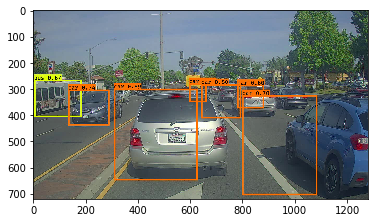

In [89]:

out_scores, out_boxes, out_classes = predict(sess, "test-Copy1.jpg")